## Analyze Trackmate Tracks
The following code computes:
 * Velocities distribuition directly from spot displacements
 * Velocitiy distribution from fitting mean-squared-displacement (MSD) curves individually 
 * Average velocity from fitting a mean MSD curve
 * Directionality from velocity auto-correlation analysis

and saves all figures and data as pdf and xlsx

### Analyze TrackMate XML File 
 * Select a TrackMate XML File ( e.g  "path / filename.xml " )
 * Plots the output of each analysis and saves figs (pdf) & data (excel)

In [ ]:
# import modules for analysis
from analyze_tracks import read, msd, velocity, utils, process
%matplotlib inline

filename = 'example/example_growth_Tracks.xml'
process.analyze_tracks(filename, clip = 0.5, plot_every = 20)

### In Batch Analysis
 * Select a folder containing TrackMate XML Files
 * Saves all figs (pdf) all data (excel)

Processing FtsZ Alone 2017.11.21 ExpIV_shrinkage_Tracks.xml


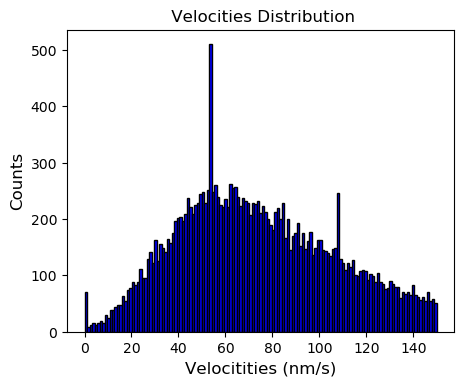

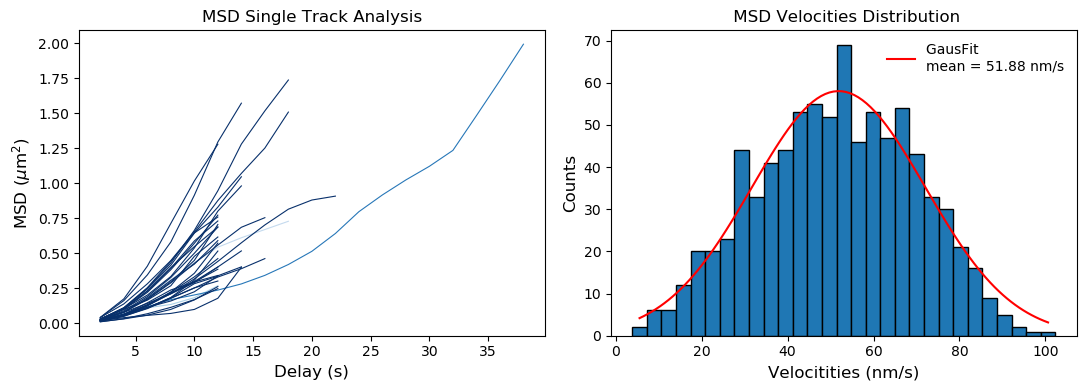

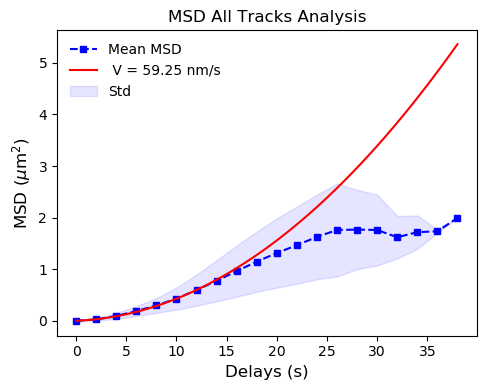

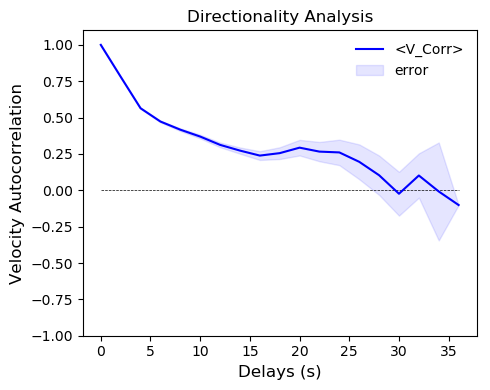

Processing FtsZ Alone 2017.12.08 ExpIV_growth_Tracks.xml


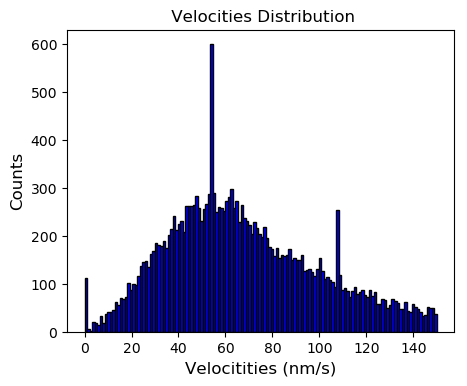

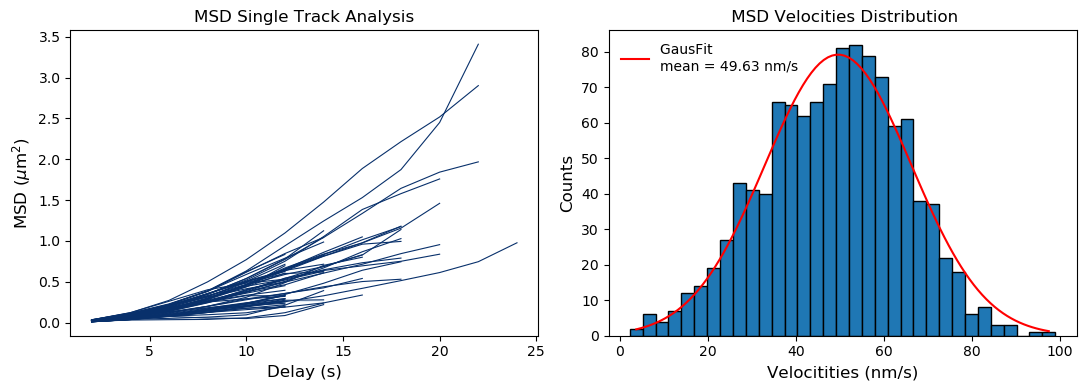

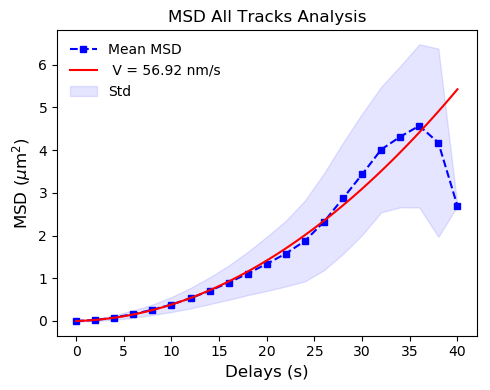

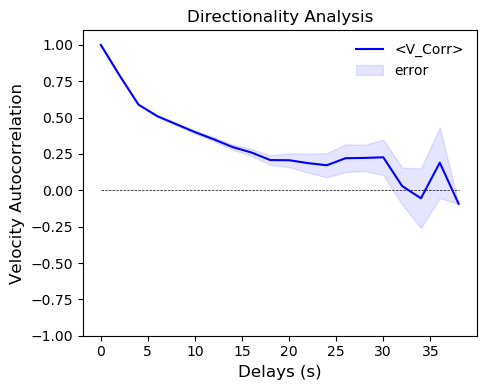

Processing FtsZ Alone 2017.12.08 ExpIV_shrinkage_Tracks.xml


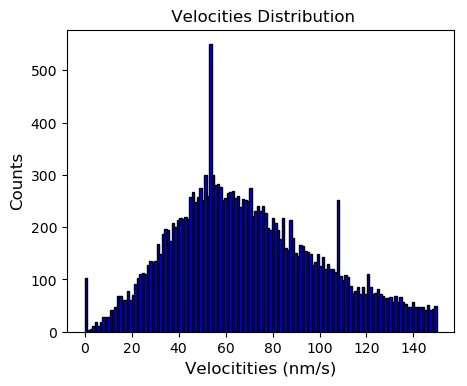

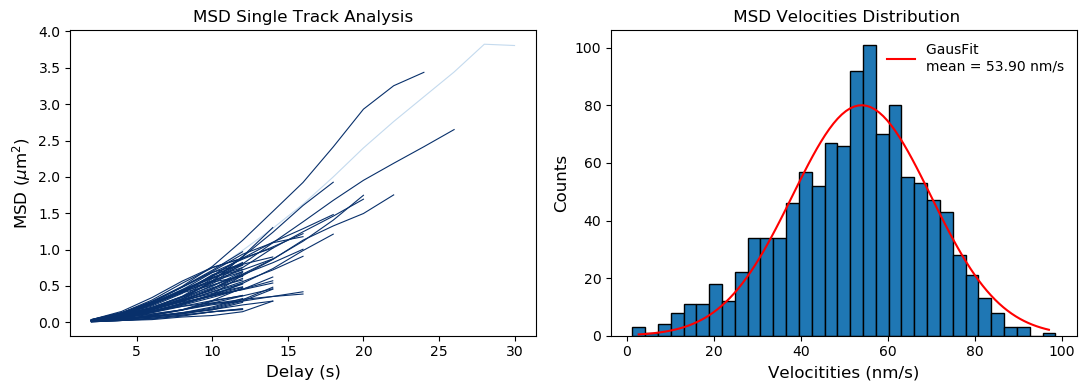

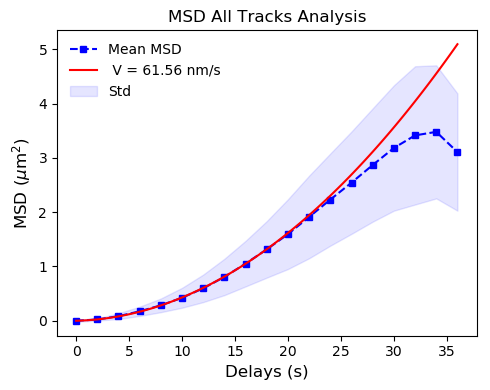

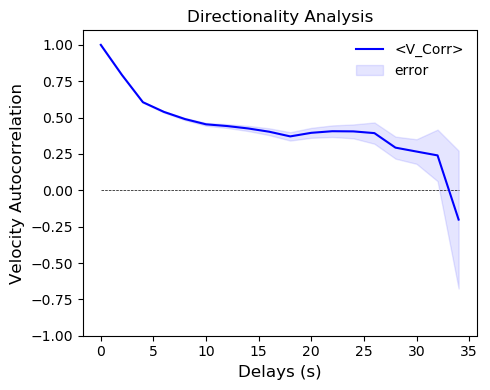

Processing FtsZ Alone 2018.01.11 ExpII_growth_Tracks.xml


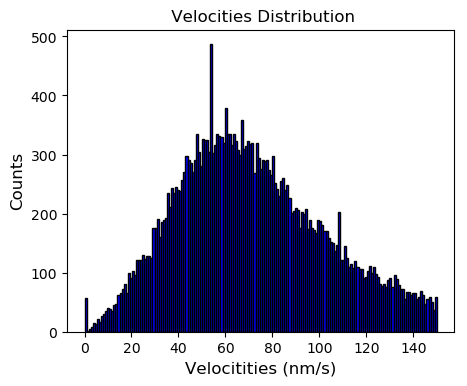

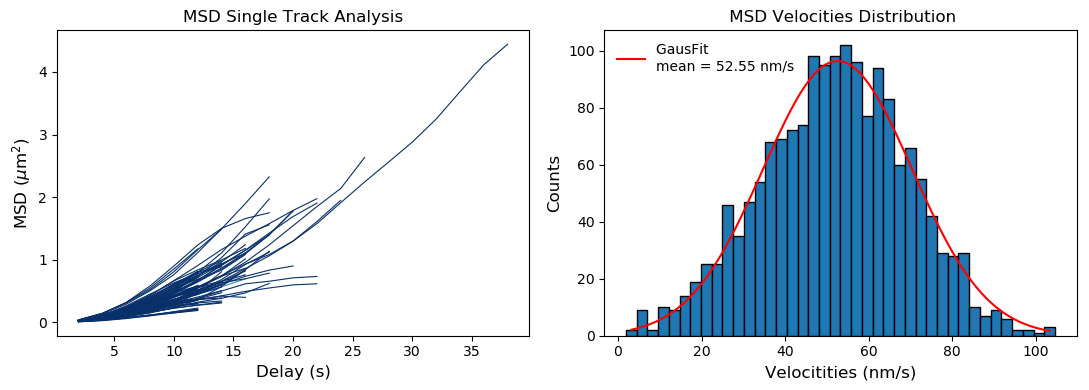

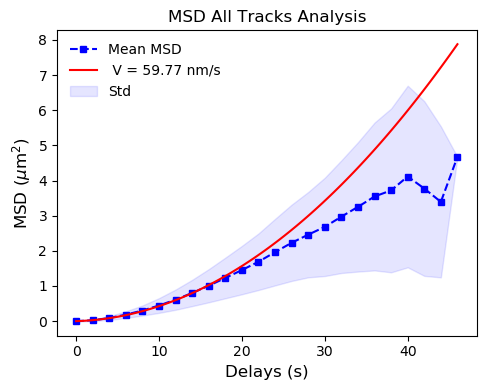

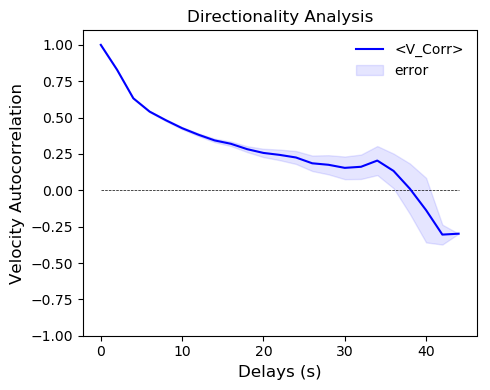

Processing FtsZ Alone 2018.01.11 ExpII_shrinkage_Tracks.xml


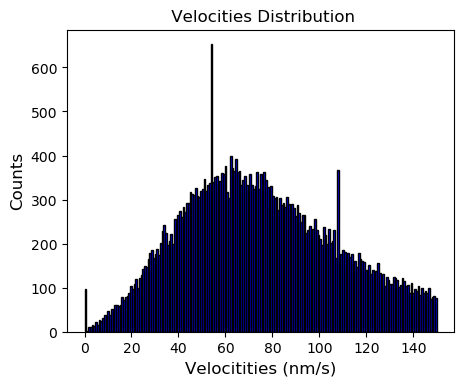

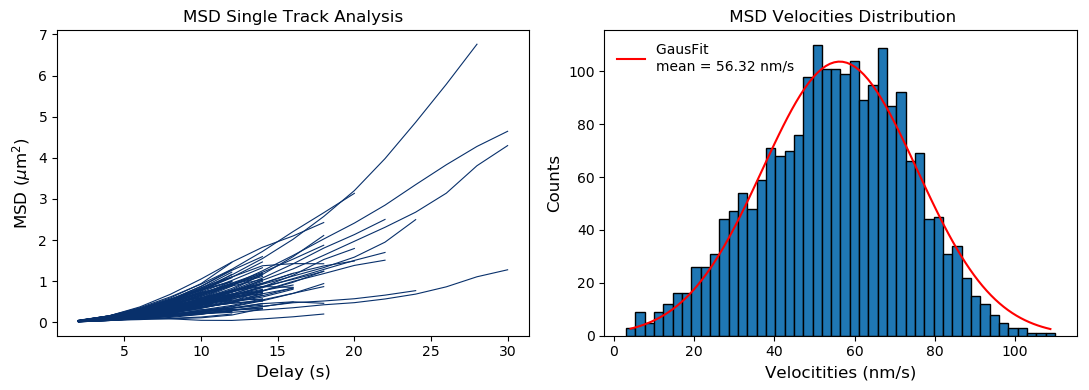

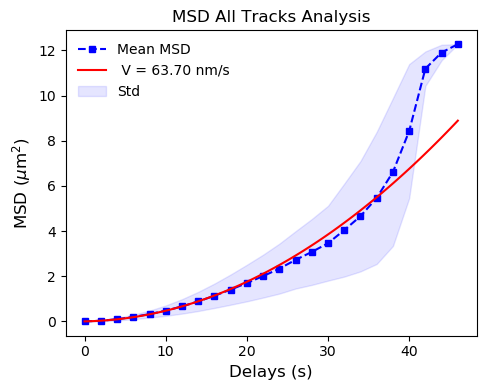

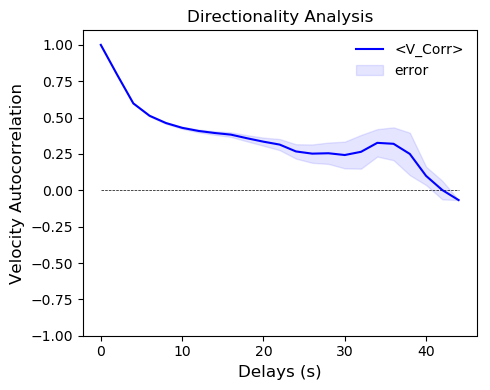

Processing FtsZ Alone 2018.01.12 ExpII_growth_Tracks.xml


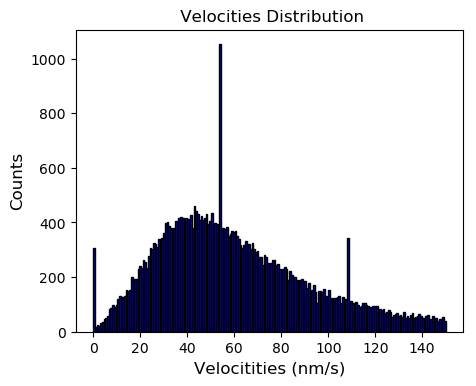

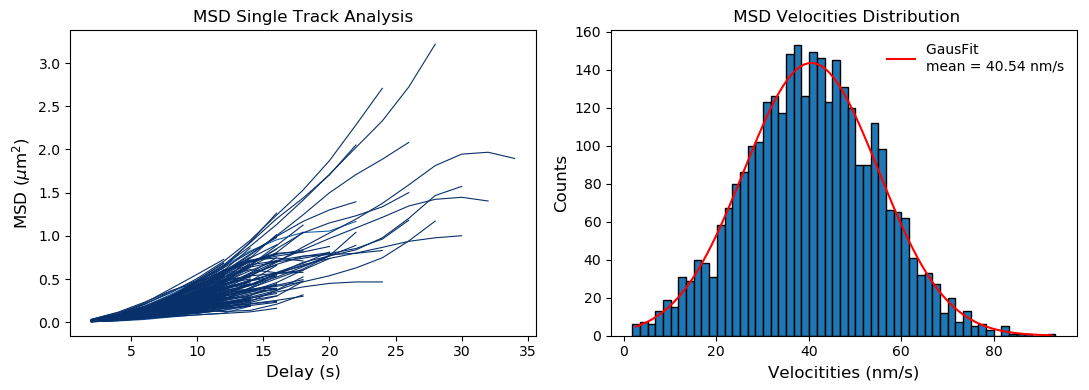

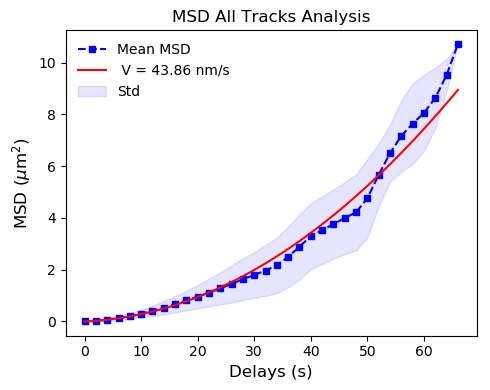

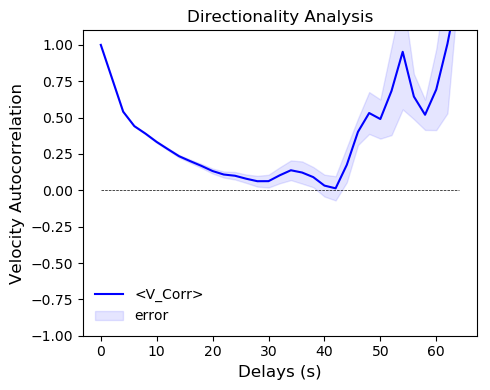



Done!


In [11]:
# import modules for analysis
from analyze_tracks import read, msd, velocity, utils, process

#folder containning xml files to analyze
files_dir = "C:/Users/pcaldas/Desktop/Data Analysis/Github/examples/"
process.analyze_tracks_batch(files_dir, clip = 0.5)